# Finding a detection strategy

The dataset consists of 8303 videos, adding to a total of **121 days, 9:29:38.669664** hours of footage. All video and audio channels were extracted and recoded, h264 codec with a frame rate of 30FPS for videos and pcm_s16le with a bitrate of 16k for a mono channeled audio.

For all videos it is required to obtain a bounding box of any present face for every frame. The GPU-backed face detector model allows to efficiently process many frames on little time. Still, running the face detector for every frame adds to a lengthy operation. The face detector is agnostic to detections on the surrounding frames leading to gaps and jittering. The first presents itself with succesive high-frequency detections that sharply change the bounding box coordinates, while the second situation is the abscence of a bounding box of a tracked face for a short period of time.

An extrapolation strategy is needed to fill any existing gaps and may mitigate jittering by smoothing the transition between detected points. Due to their availability spline interpolators of zeroth, first, second and third order were compared with sampling rates of 15, 6, and 3 FPS to build the interpolated models.

+ Does lowering the frame rate make an improovement on detection time?
    + By how much?
    + Thresholding the frame size to a maximum value may help too, what dimensions to use as threshold?
+ Averaging past detections decrease the jittering?
    + Which performs the best?
+ Which interpolation strategy is closer to the true detection?
    + Which is closer to the softened detection?

In [2]:
%matplotlib inline
import json
from datetime import timedelta
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.interpolate import interp1d

## Speedup by lowering frame rate

The following test corroborate that frame detection can be sped-up by lowering the detection frame rate. For this analysis a sample of 150 files were randomly chosen and procesed with different frame rates.

In [3]:
experiments = [
    {'folder': r'../data/test_tracks@30FPS', 'label': '30FPS'},
    {'folder': r'../data/test_tracks@15FPS', 'label': '15FPS'},
    {'folder': r'../data/test_tracks@6FPS', 'label': '6FPS'},
    {'folder': r'../data/test_tracks@3FPS', 'label': '3FPS'},
]

for d in experiments:
    d['video_length'] = []
    d['time_detecting'] = []
    d['width'] = []
    d['height'] = []
    d['track_length'] = []
    
    for track_file in Path(d['folder']).glob('**/*.tracks.json'):
        with track_file.open('r', encoding='utf8') as fp:
            track_file = json.load(fp)
        
        if len(track_file['tracks']) == 0:
            continue
        
        # Video data
        d['video_length'].append(track_file['video_duration'])
        d['time_detecting'].append(track_file['detection_duration'])
        d['width'].append(track_file['width'])
        d['height'].append(track_file['height'])
        d['track_length'].extend([t['time'][-1] for t in track_file['tracks'].values()])

    print(f"{d['label']}:")
    print('  - Total video length:', timedelta(seconds=sum(d['video_length'])))
    print('  - Total time detecting:', timedelta(seconds=sum(d['time_detecting'])))
    print('  - Total track length:', timedelta(seconds=sum(d['track_length'])))

30FPS:
  - Total video length: 14:36:48.266667
  - Total time detecting: 12:16:10.141013
  - Total track length: 11 days, 7:40:26.266667
15FPS:
  - Total video length: 1 day, 21:05:37.733333
  - Total time detecting: 15:48:41.328386
  - Total track length: 41 days, 4:59:39
7FPS:
  - Total video length: 1 day, 20:07:13.400000
  - Total time detecting: 8:39:35.024867
  - Total track length: 39 days, 0:13:13
3FPS:
  - Total video length: 1 day, 19:55:26.200000
  - Total time detecting: 5:56:41.302896
  - Total track length: 35 days, 23:05:48.333333


Mean speedup @30FPS:1.5536351203918457	Rectified mean speedup@30FPS:2.721698522567749
Mean speedup @15FPS:4.448965549468994	Rectified mean speedup@15FPS:7.620915412902832
Mean speedup @7FPS:8.450945854187012	Rectified mean speedup@7FPS:15.537521362304688
Mean speedup @3FPS:13.249807357788086	Rectified mean speedup@3FPS:25.553577423095703


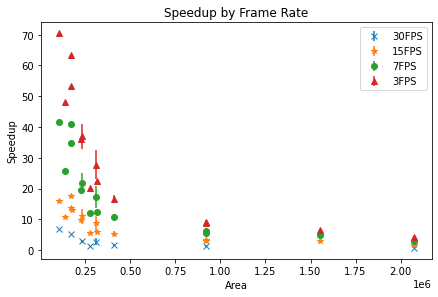

In [4]:
fig = plt.figure()
ax = plt.axes()
markers='x*o^'
for i, d in enumerate(experiments):
    all_area = np.float32(d['width']) * np.float32(d['height'])
    all_speedup = np.float32(d['video_length']) / np.float32(d['time_detecting'])
    
    w = 1.0 / all_area
    w = w / np.sum(w)
    speedup_rectified_by_area = np.average(all_speedup, weights=w)
    
    print(f'Mean speedup @{d["label"]}:{np.mean(all_speedup)}\tRectified mean speedup@{d["label"]}:{speedup_rectified_by_area}')
    
    area = np.sort(np.unique(all_area))
    speedup = [np.mean(all_speedup[all_area == i]) for i in area]
    speedup_err = [np.std(all_speedup[all_area == i]) for i in area]
    ax.errorbar(area, speedup, yerr=speedup_err, fmt=markers[i], label=d['label'])

fig.tight_layout()
plt.title('Speedup by Frame Rate')
plt.xlabel('Area')
plt.ylabel('Speedup')
plt.legend()
plt.show()

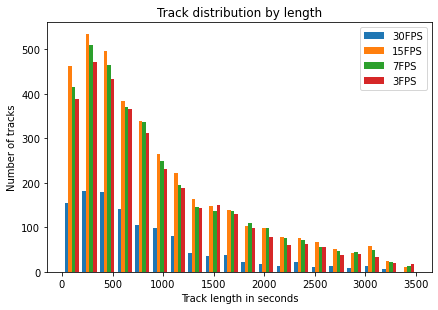

In [28]:
# Track distribution by duration color by framerate
fig = plt.figure()
ax = plt.axes()


ax.hist([d['track_length'] for d in experiments], bins=20)

fig.tight_layout()
plt.title('Track distribution by length')
plt.xlabel('Track length in seconds')
plt.ylabel('Number of tracks')
plt.legend([d['label'] for d in experiments])
plt.show()

## Track Data
We use only the 30FPS, subsampling to the lower frame rates using time.

In [6]:
DATA_PATH = Path(r'../data/test_tracks@30FPS')
DATA_FRAME_RATE = 30
DATA_PERIOD = 1.0 / float(DATA_FRAME_RATE)

data_time = []
data_bbox = []
data_kpts = []
data_tlen = []

for track_file in DATA_PATH.glob('**/*.tracks.json'):
    with track_file.open('r', encoding='utf8') as fp:
        track_file = json.load(fp)
    
    # Ignore videos without tracks
    if len(track_file['tracks']) == 0:
        continue
        
    track_time, track_bbox, track_kpts = zip(*[(t['time'], t['bbox'], t['kpts']) for t in track_file['tracks'].values()])
        
    track_time = list(track_time)
    track_bbox = list(track_bbox)
    track_kpts = list(track_kpts)
    track_tlen = []
    
    for i, (t, b, k) in enumerate(zip(track_time, track_bbox, track_kpts)):        
        # All tracks start from 0
        t = np.float32(t) - t[0]
        track_time[i] = t.tolist()
        
        # Length of a track in seconds
        track_tlen.append(t[-1])
        
        # Box positions from screen center
        b = np.float32(b).reshape(-1, 2, 2)
        b[:, :, 0] -= 0.5 * track_file['width']
        b[:, :, 1] -= 0.5 * track_file['height']
        track_bbox[i] = b.tolist()
        
        # Point positions from screen center
        k = np.float32(k).reshape(-1, 5, 2)
        k[:, :, 0] -= 0.5 * track_file['width']
        k[:, :, 1] -= 0.5 * track_file['height']
        track_kpts[i] = k.tolist()
    
    data_time.extend(track_time)
    data_bbox.extend(track_bbox)
    data_kpts.extend(track_kpts)
    data_tlen.extend(track_tlen)

num_tracks = len(data_time)
print('There are', num_tracks, 'tracks')

There are 1183 tracks


### Sampling tracks
Pick random track and a starting point.

In [7]:
SAMPLE_LENGTH = 5.0
SAMPLE_NUM = 1000
np.random.seed(0)

# Pick random track and a random position to start a slice
track_samples = (np.random.random(SAMPLE_NUM) * len(data_time)).astype(int)
track_start = np.random.random(SAMPLE_NUM) * (np.float32(data_tlen)[track_samples] - SAMPLE_LENGTH)

test_time = []
test_bbox = []
test_kpts = []

for ti, ts in zip(track_samples, track_start):
    t_time = []
    t_bbox = []
    t_kpts = []
    # Add the frames that lie between the picked slice bounds
    for i in range(len(data_time[ti])):
        if ts <= data_time[ti][i] < ts + SAMPLE_LENGTH:
            t_time.append(data_time[ti][i])
            t_bbox.append(data_bbox[ti][i])
            t_kpts.append(data_kpts[ti][i])
    # Make slices start from 0
    test_time.append(np.float32(t_time) - t_time[0])
    test_bbox.append(np.float32(t_bbox))
    test_kpts.append(np.float32(t_kpts))

## Compensating for the jittering
30FPS is too high-frequency, it introduces jittering.

Jittering is an undesired problem on the high-frequency 30FPS tracked boxes used as reference samples. Applying a moving window averaging the previous elements acts as a low-pass filter reducing the jitter. Three weighting strategies were used: uniform, lineal and gaussian.

+ Uniform estrategy averages the last n elements with equal weights.
+ Linear strategy weights the elements by the time-distance to the current sample, normalized by the longest.
+ Gaussian strategy weights by the gaussian value on the time-axis, centered on the current sample with a standard deviation of the detection period.

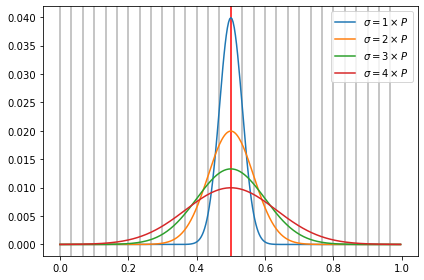

In [8]:
def gaussian(x, mu, sigma):
    return (1.0 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((x - mu)**2) / (2 * sigma**2))

fig = plt.figure()
ax = plt.axes()

for x in np.arange(0, 1, DATA_PERIOD):
    if x == 0.5:
        color = 'red'
    else:
        color = '#0f0f0f50'
    plt.axvline(x=x, color=color)

x = np.arange(0, 1, DATA_PERIOD / 10.0)
for i in range(1, 5):
    y = gaussian(x, 0.5, DATA_PERIOD * i)
    y = y / np.sum(y)
    ax.plot(x, y, label=f'$\sigma={i} \\times P$')

fig.tight_layout()
plt.legend()
plt.show()

On the previous figure, the vertical lines are equally distance by the time between frames, or period $P$. For the third previous element, its contribution is close to zero.

Thus the weight of element $j$ with respect to element $i$ is:
$
W(t_j, t_i)=
\begin{cases}
    \frac{1}{P \sqrt{2 \pi}} e^{-\frac{1}{2}(\frac{t_j-t_i}{P})^2} & \forall j <= i\\
    0 & \text{otherwise}.
\end{cases}
$

In [9]:
def soften(x, y, win_size, fn):
    soft_y = []
    for c in range(len(x)):
        istart = max(c - win_size, 0)
        iend = c + 1
        # iend = min(c + win_size, len(x)-1)
        weights = fn(x[istart:iend])
        weights = weights / np.sum(weights)
        soft_y.append(np.average(y[istart:iend], weights=weights, axis=0))
    return np.float32(soft_y)

def mse(x0, x1):
    return np.mean((x0 - x1)**2)

test_cases = { 
    'Uniform': lambda x: np.ones_like(x),
    'Linear': lambda x: 1.0 / (np.abs(x - x[-1]) + 1.0),
    'Gaussian': lambda x: gaussian(x, x[-1], DATA_PERIOD),
}

softened_bbox = {k: [] for k in test_cases}
cat_test_bbox = np.concatenate(test_bbox)
for label, op in test_cases.items():
    for true_time, true_bbox in zip(test_time, test_bbox):    
        soft_bbox = soften(true_time, true_bbox, 5, op)
        softened_bbox[label].append(soft_bbox)
    print(label, 'MSE:', mse(cat_test_bbox, np.concatenate(softened_bbox[label])))

Uniform MSE: 44.689922
Linear MSE: 42.17731
Gaussian MSE: 7.7788424


Gaussian weights is the best!
Now an example with centers and areas to show it.

Uniform 72.942184
Linear 69.61555
Gaussian 17.169903


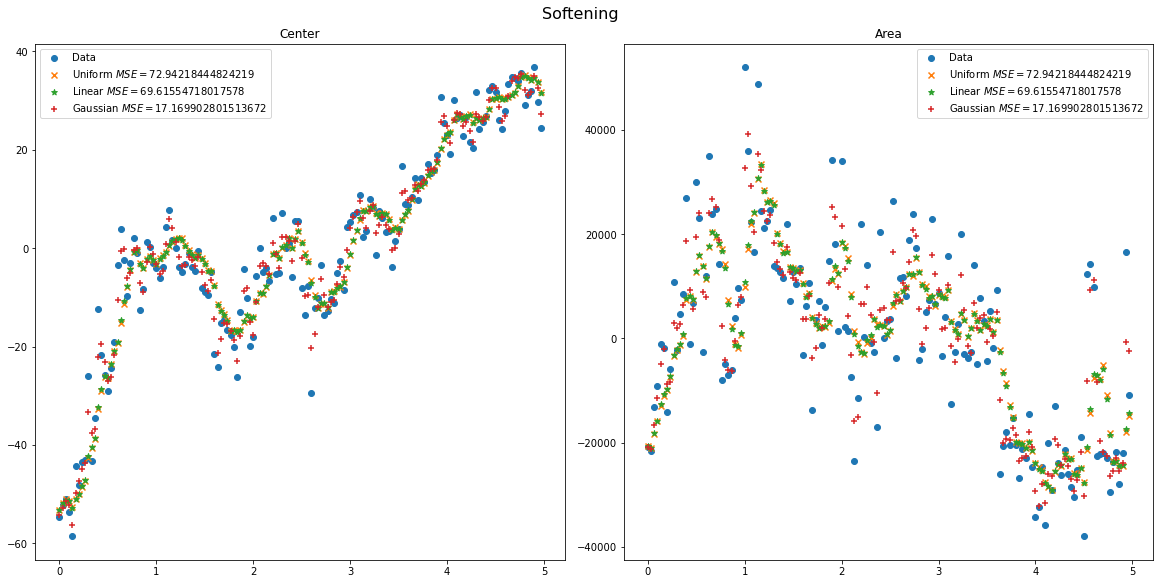

In [10]:
NROWS, NCOLS = 1, 2
EXAMPLE_IDX = 1

def get_center_area(bbox):
    cter = np.sqrt(np.sum((0.5 * np.sum(bbox, axis=1))**2, axis=-1))
    area = (bbox[:, 1, 0] - bbox[:, 0, 0]) * (bbox[:, 1, 1] - bbox[:, 0, 1])
    cter = cter - np.mean(cter)
    area = area - np.mean(area)
    return cter, area

def get_error(ldiff):
    udiff = -ldiff
    ldiff[ldiff < 0] = 0
    udiff[udiff < 0] = 0
    return (ldiff, udiff)

true_time = test_time[EXAMPLE_IDX]
true_bbox = test_bbox[EXAMPLE_IDX]
    
fig, axs = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(8*NCOLS, 8*NROWS),
                        constrained_layout=True, squeeze=False)
cter_ax = axs[0, 0]
area_ax = axs[0, 1]

true_cter, true_area = get_center_area(true_bbox)
cter_ax.scatter(true_time, true_cter, marker='o', label='Data')
area_ax.scatter(true_time, true_area, marker='o', label='Data')

# Plot softened data with the displacement from True with an error bar
for (label, op), m in zip(test_cases.items(), 'x*+'):
    soft_bbox = soften(true_time, true_bbox, 5, op)
    soft_cter, soft_area = get_center_area(soft_bbox)
    
    mse_err = mse(test_bbox[EXAMPLE_IDX], softened_bbox[label][EXAMPLE_IDX])
    print(label, mse_err)
    
    cter_ax.scatter(true_time, soft_cter, marker=m, label=label + f' $MSE={mse_err}$')
    area_ax.scatter(true_time, soft_area, marker=m, label=label + f' $MSE={mse_err}$')
    
cter_ax.set_title('Center')
cter_ax.legend()
area_ax.set_title('Area')
area_ax.legend()

fig.suptitle('Softening', fontsize=16)
plt.show()

## Interpolation Strategies

variables:

+ 'zero', 'slinear', 'quadratic', 'cubic'
+ gaussian window or not
+ 15, 6, 3 FPS

In [11]:
op = lambda x: gaussian(x, x[-1], DATA_PERIOD)

def select_times(in_times, in_period, out_period):
    out_times = np.round(in_times / in_period).astype(int)
    k = int(np.round(out_period / in_period))
    out_times = np.mod(out_times, k)
    return np.argwhere(out_times == 0)

interpolation_kinds = ['zero', 'slinear', 'quadratic', 'cubic']
frame_rates = [15, 6, 3]
soft_type = ['', '+Gauss']

reference_soft_bbox = [soften(time, bbox, 5, op) for time, bbox in zip(test_time, test_bbox)]
cat_reference_soft_bbox = np.concatenate(reference_soft_bbox)

mse_results = {}
mse_soft_results = {}
transformed_bbox = {}
for fr in frame_rates:
    for kind in interpolation_kinds:
        for is_soft in soft_type:
            label = f'{kind}{is_soft}@{fr}FPS'
            transformed_bbox[label] = transformed_bbox.get(label, [])
            
            for true_time, true_bbox in zip(test_time, test_bbox):
                idx = select_times(true_time, DATA_PERIOD, 1.0 / fr)
                time = true_time[idx].flatten()
                bbox = true_bbox[idx].reshape(-1, 2, 2)
                
                if len(is_soft) != 0:
                    bbox = soften(time, bbox, 5, op)
                try:
                    bbox_inter = interp1d(time, bbox, kind=kind, bounds_error=False, fill_value='extrapolate', axis=0)
                    y = bbox_inter(true_time)
                except ValueError as e:
                    y = np.zeros_like(true_bbox)
                transformed_bbox[label].append(y)
            
            mse_true = mse(cat_test_bbox, np.concatenate(transformed_bbox[label]))
            mse_soft = mse(cat_reference_soft_bbox, np.concatenate(transformed_bbox[label]))
            
            mse_results[label] = mse_true
            mse_soft_results[label] = mse_soft
            print(label, 'MSE:', mse_true, 'Soft MSE:', mse_soft)

zero@15FPS MSE: 23.660635676067916 Soft MSE: 12.850826343666165
zero+Gauss@15FPS MSE: 23.144732524463258 Soft MSE: 10.637040710676056
slinear@15FPS MSE: 15.454337882513975 Soft MSE: 11.101275516423447
slinear+Gauss@15FPS MSE: 15.56445509986673 Soft MSE: 8.61447633738515
quadratic@15FPS MSE: 18.51042156991736 Soft MSE: 13.824927030875669
quadratic+Gauss@15FPS MSE: 17.656728713224968 Soft MSE: 10.301601985034878
cubic@15FPS MSE: 24.042387826591273 Soft MSE: 19.295577559148626
cubic+Gauss@15FPS MSE: 21.27860905287899 Soft MSE: 13.849021543641987
zero@7FPS MSE: 51.37393280602053 Soft MSE: 33.4744635838961
zero+Gauss@7FPS MSE: 51.37235090776644 Soft MSE: 33.469479572693196
slinear@7FPS MSE: 28.67362232997474 Soft MSE: 19.326934948851548
slinear+Gauss@7FPS MSE: 28.670448804739316 Soft MSE: 19.317991815567794
quadratic@7FPS MSE: 48.28004384834738 Soft MSE: 38.63051771439748
quadratic+Gauss@7FPS MSE: 48.25824112225414 Soft MSE: 38.6027401265139
cubic@7FPS MSE: 262.56055361347825 Soft MSE: 252.

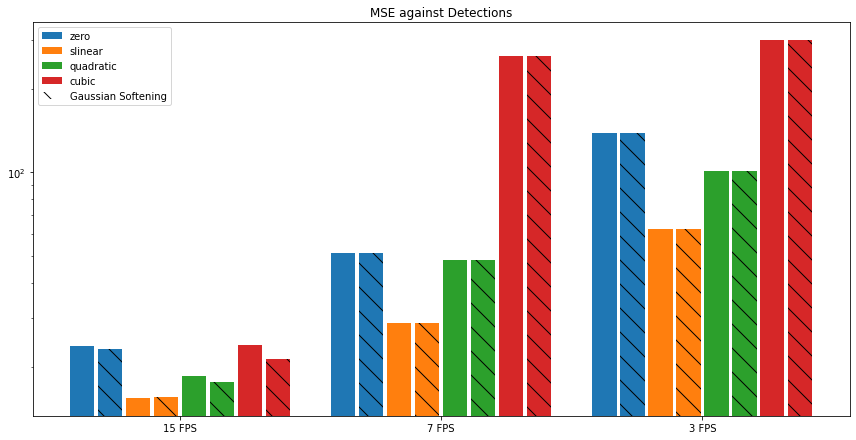

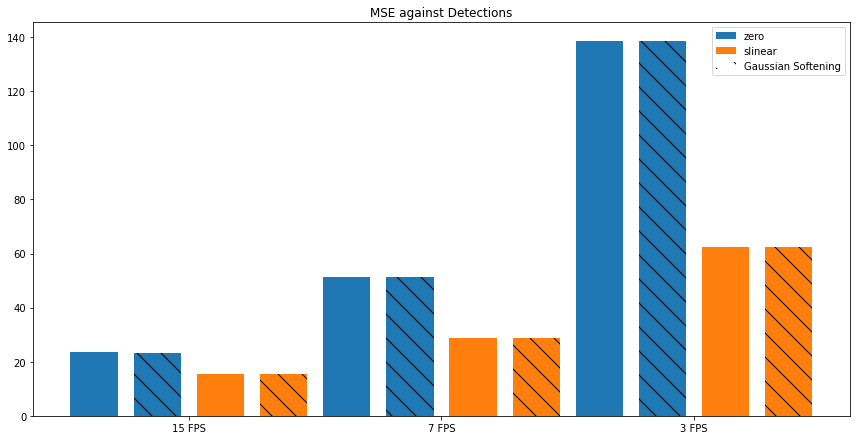

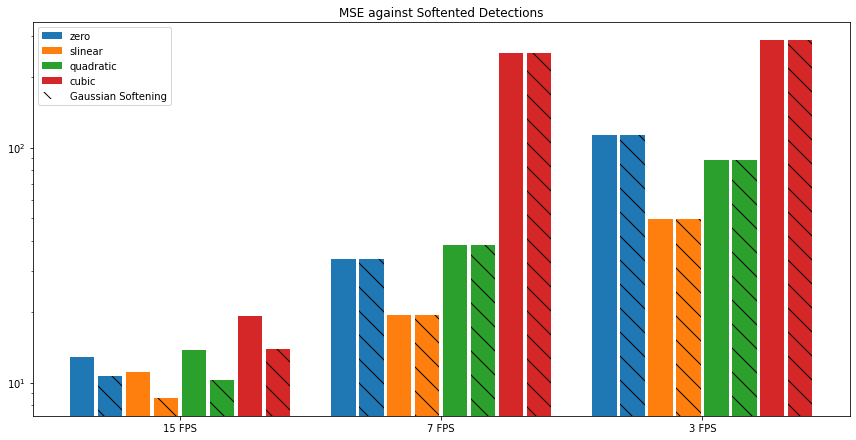

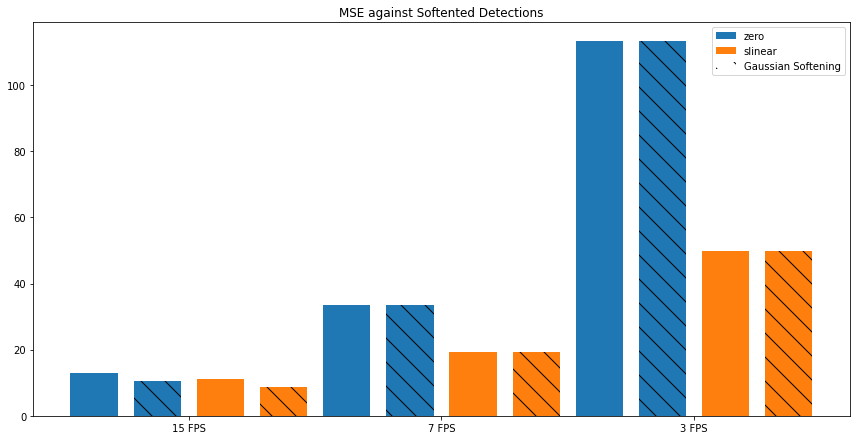

In [12]:
width = 0.75
hatch_pattern = '\\'

def plot_fig(results, interpolation_kinds, use_log, title):
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes()

    positions = np.stack([np.linspace(i - width / 2, i + width/2, len(soft_type) * len(interpolation_kinds))
                          for i in np.arange(len(frame_rates))])
    positions = positions.reshape(len(frame_rates), len(interpolation_kinds), len(soft_type))

    for i, kind in enumerate(interpolation_kinds):
        values = []
        for fr in frame_rates:
            values.extend([results[f'{kind}{is_soft}@{fr}FPS'] for is_soft in soft_type])
        b = ax.bar(positions[:, i].flatten(), values, width / (len(soft_type) * len(interpolation_kinds)), label=kind)
        for k, bb in enumerate(b):
            if k % 2 == 1:
                bb.set_hatch(hatch_pattern)
    if use_log:
        ax.set_yscale('log')
    fig.tight_layout()
    plt.xticks(np.arange(len(frame_rates)), [f'{fr} FPS' for fr in frame_rates])
    handles, labels = ax.get_legend_handles_labels()
    handles.append(Patch(facecolor='w', hatch=hatch_pattern, label='Gaussian Softening'))
    plt.legend(handles=handles)
    plt.title(title)
    plt.show()

plot_fig(mse_results, ['zero', 'slinear', 'quadratic', 'cubic'], True, 'MSE against Detections')
plot_fig(mse_results, ['zero', 'slinear'], False, 'MSE against Detections')
plot_fig(mse_soft_results, ['zero', 'slinear', 'quadratic', 'cubic'], True, 'MSE against Softented Detections')
plot_fig(mse_soft_results, ['zero', 'slinear'], False, 'MSE against Softented Detections')

+ Does lowering the frame rate make an improovement on detection time? Yes
    + By how much? From 3:1 @30FPS to X:1 @15FPS
    + Thresholding the frame size to a maximum value may help too, what dimensions to use as threshold?
+ Averaging past detections decrease the jittering? Yes
    + Which performs the best? Gaussian
+ Which interpolation strategy is closer to the true detection? slinear @15FPS
    + Which is closer to the softened detection? slinear @15FPS